In [56]:
import os 
root_dir = os.path.abspath('')
os.chdir(root_dir)

In [57]:
import warnings
warnings.filterwarnings('ignore')

# Library

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.eda import *
from src.feat_select import *

(CVXPY) Mar 17 12:33:22 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 17 12:33:22 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [3]:
import importlib
from src import eda
importlib.reload(eda)
from src.eda import *

In [4]:
df = pd.read_csv('data/train_data.txt')
df_test = pd.read_csv('data/test_data.txt')

In [5]:
print('Train: ', len(df))
print('Test: ', len(df_test))

Train:  5822
Test:  4000


In [6]:
print('Event rate ', df['86'].value_counts()/len(df['86']))

Event rate  86
0    0.940227
1    0.059773
Name: count, dtype: float64


In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5822 non-null   int64
 1   1       5822 non-null   int64
 2   2       5822 non-null   int64
 3   3       5822 non-null   int64
 4   4       5822 non-null   int64
 5   5       5822 non-null   int64
 6   6       5822 non-null   int64
 7   7       5822 non-null   int64
 8   8       5822 non-null   int64
 9   9       5822 non-null   int64
 10  10      5822 non-null   int64
 11  11      5822 non-null   int64
 12  12      5822 non-null   int64
 13  13      5822 non-null   int64
 14  14      5822 non-null   int64
 15  15      5822 non-null   int64
 16  16      5822 non-null   int64
 17  17      5822 non-null   int64
 18  18      5822 non-null   int64
 19  19      5822 non-null   int64
 20  20      5822 non-null   int64
 21  21      5822 non-null   int64
 22  22      5822 non-null   int64
 23  23      5822 

In [8]:
demo_feat = [str(i) for i in range(1,43)]
prod_own_feat = [str(i) for i in range(43, 86)]
label = ['86']

# Data processing + Feature creation

In [9]:
def regroup(row):
    if row in (1,2,3,4,7):
        return 3
    elif row in (8,9,10,11,12,13,14,15,22,26,27,28,29,30,34,35,36,37,38):
        return 2
    elif row in (16,17,18,19,21,23,24,25,31,33,41):
        return 1
    else:
        return 0

In [10]:
df['social_class'] = df['1'].apply(lambda row: regroup(row)) 

In [11]:
def most_cat(df, feature):
    total_obs = len(df)
    most_cat = df[feature].value_counts().max()
    rate = most_cat/total_obs
    return rate

In [12]:
frequency_rate = {'feature':[], 'rate':[]}
for feature in (demo_feat+prod_own_feat):
    frequency_rate['feature'].append(feature)
    frequency_rate['rate'].append(most_cat(df, feature))

In [13]:
freq_rate = pd.DataFrame(frequency_rate).sort_values(by='rate', ascending=False).reset_index(drop=True)
drop_list = list(freq_rate[freq_rate['rate']>= 0.8].feature)

In [14]:
#total contribution level/amount
df['total_con_level'] = df.iloc[:, 44:66].sum(axis=1)

#total number of policy owned
df['total_no_policy'] = df.iloc[:, 65:86].sum(axis=1)

#total amount contributed per policies
for amt, count in zip(range(44,65), range(65,86)):
    df[f'{amt}_amt'] = df[f'{amt}']*df[f'{count}']

In [15]:
#scan to see which policies have the most contribution/ownership amount

df.iloc[:, 90:111].sum(axis=0).sort_values(ascending=False)

#47 = car insurance
#59 = fire insurance
#44 = private 3rd party insurance
#55 = life insurance

47_amt    19142
59_amt    11388
44_amt     4507
55_amt     1765
54_amt     1305
49_amt     1124
52_amt      804
46_amt      417
48_amt      366
64_amt      280
45_amt      257
62_amt      185
58_amt      161
51_amt      152
53_amt      151
61_amt      118
63_amt       95
57_amt       89
50_amt       85
56_amt       80
60_amt        5
dtype: int64

In [16]:
#total amount all policies
df['total_all_policy'] = df.iloc[:, 90:111].sum(axis=1)

def treat_divide_by_zero(df, feat):
    set_limit = df[df[feat]!=np.inf][feat].max()
    df[feat] = df[feat].replace({np.inf:set_limit, -np.inf:0})

#ratio average income/total amount all policies
df['income_vs_policy'] = df['42']/df['total_all_policy']
treat_divide_by_zero(df, 'income_vs_policy')

#ratio average income/insurance type (most popular types)
for i in [47,59,44,55]:
    new_col = f'income_vs{i}'
    df[new_col]=df['42']/df[f'{i}_amt']
    treat_divide_by_zero(df, new_col)

df.fillna(0, inplace=True)

In [17]:
def data_processing(df_input):

    df = df_input.copy()
    df['social_class'] = df['1'].apply(lambda row: regroup(row)) 
    #total contribution level/amount
    df['total_con_level'] = df.iloc[:, 44:66].sum(axis=1)
    
    #total number of policy owned
    df['total_no_policy'] = df.iloc[:, 65:86].sum(axis=1)
    
    #total amount contributed per policies
    for amt, count in zip(range(44,65), range(65,86)):
        df[f'{amt}_amt'] = df[f'{amt}']*df[f'{count}']
    #total amount all policies
    df['total_all_policy'] = df.iloc[:, 90:111].sum(axis=1)
    
    def treat_divide_by_zero(df, feat):
        set_limit = df[df[feat]!=np.inf][feat].max()
        df[feat] = df[feat].replace({np.inf:set_limit, -np.inf:0})
    
    #ratio average income/total amount all policies
    df['income_vs_policy'] = df['42']/df['total_all_policy']
    treat_divide_by_zero(df, 'income_vs_policy')
    
    #ratio average income/insurance type (most popular types)
    for i in [47,59,44,55]:
        new_col = f'income_vs{i}'
        df[new_col]=df['42']/df[f'{i}_amt']
        treat_divide_by_zero(df, new_col)

    df.fillna(0, inplace=True)        
    return df

In [18]:
df_test['86']=None

In [19]:
df_test_final = data_processing(df_test)

In [20]:
df = data_processing(df)

# EDA

In [21]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 117 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    ID                5822 non-null   int64  
 1    1                 5822 non-null   int64  
 2    2                 5822 non-null   int64  
 3    3                 5822 non-null   int64  
 4    4                 5822 non-null   int64  
 5    5                 5822 non-null   int64  
 6    6                 5822 non-null   int64  
 7    7                 5822 non-null   int64  
 8    8                 5822 non-null   int64  
 9    9                 5822 non-null   int64  
 10   10                5822 non-null   int64  
 11   11                5822 non-null   int64  
 12   12                5822 non-null   int64  
 13   13                5822 non-null   int64  
 14   14                5822 non-null   int64  
 15   15                5822 non-null   int64  
 16   16                5822

<Figure size 640x480 with 0 Axes>

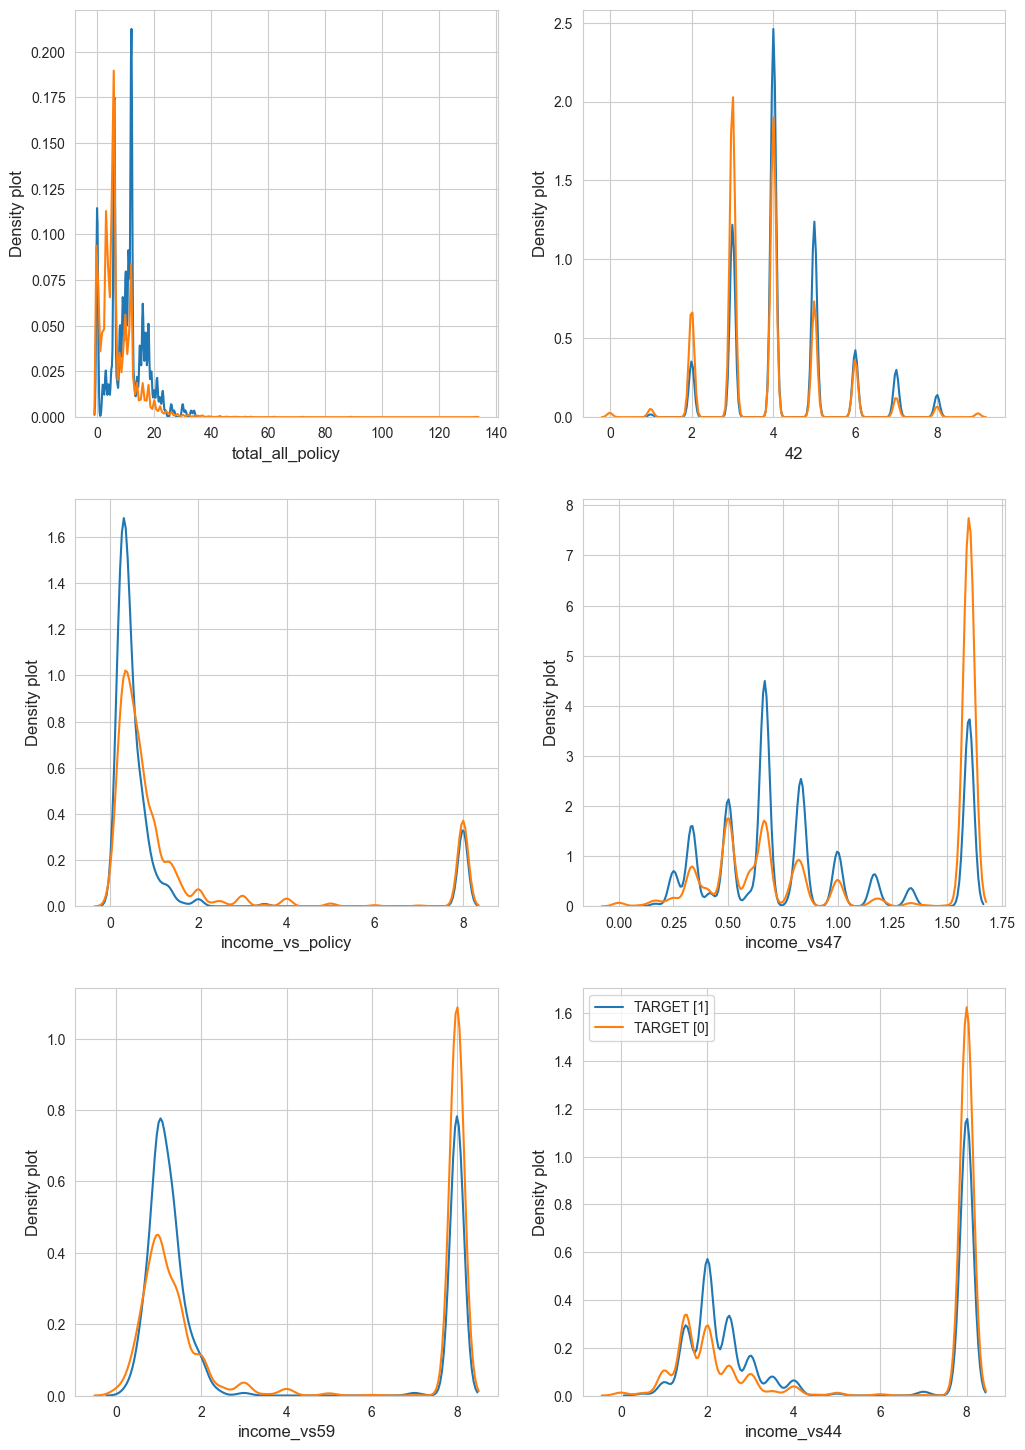

In [22]:
plot_distribution_target(df, ['total_all_policy', '42', 'income_vs_policy', 'income_vs47', 'income_vs59', 'income_vs44'], label[0], nrows=3, bw_method=0.05)

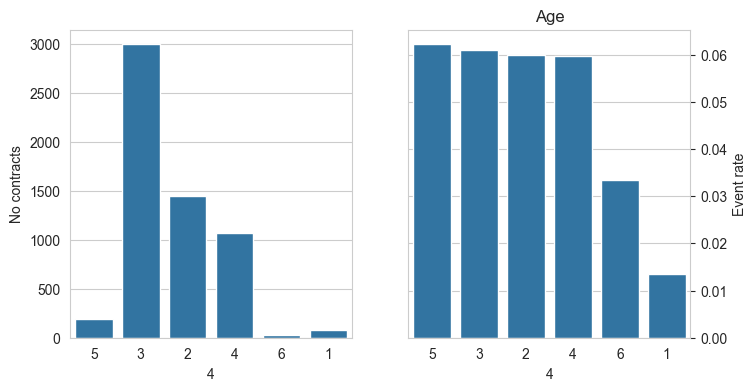

In [23]:
plot_stats('4', label[0], df, title='Age')

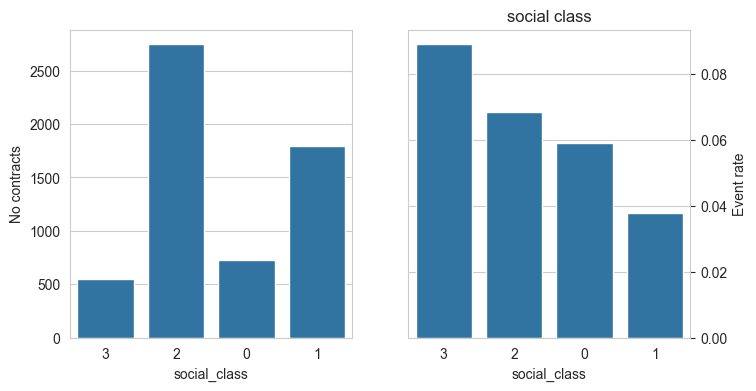

In [24]:
plot_stats('social_class', label[0], df, title='social class')

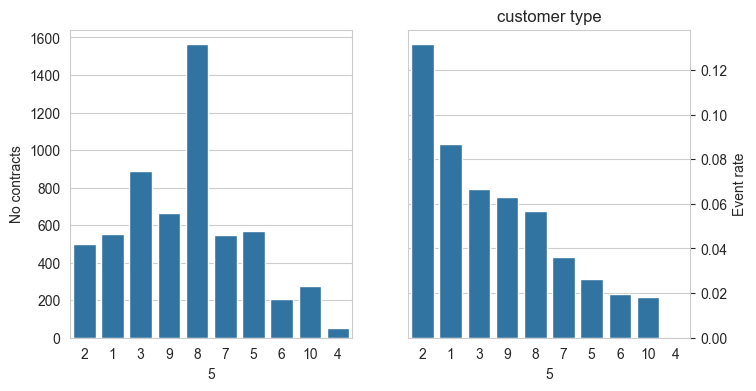

In [25]:
plot_stats('5', label[0], df, title='customer type')

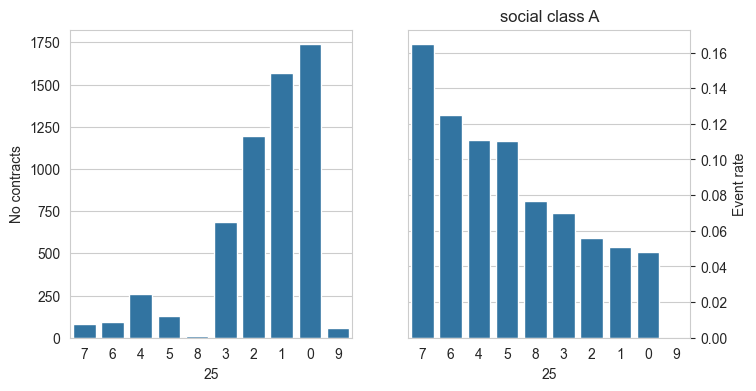

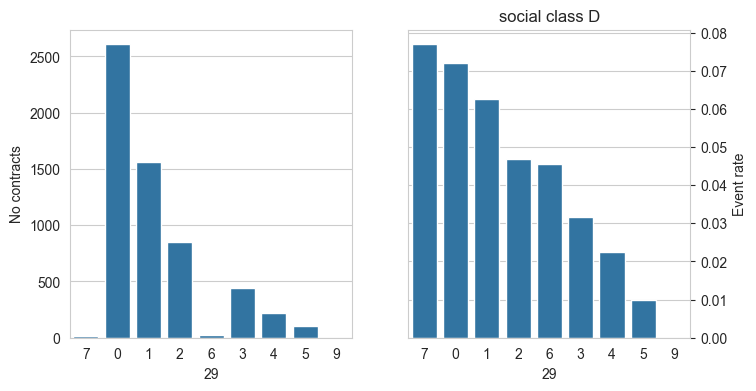

In [26]:
plot_stats('25', label[0], df, title='social class A')
plot_stats('29', label[0], df, title='social class D')

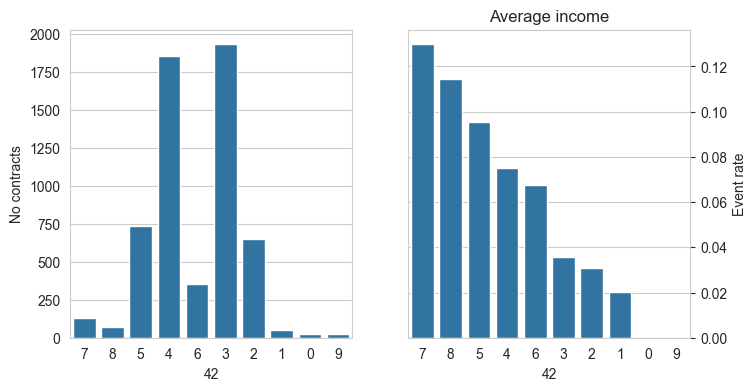

In [27]:
plot_stats('42', label[0], df, title='Average income')

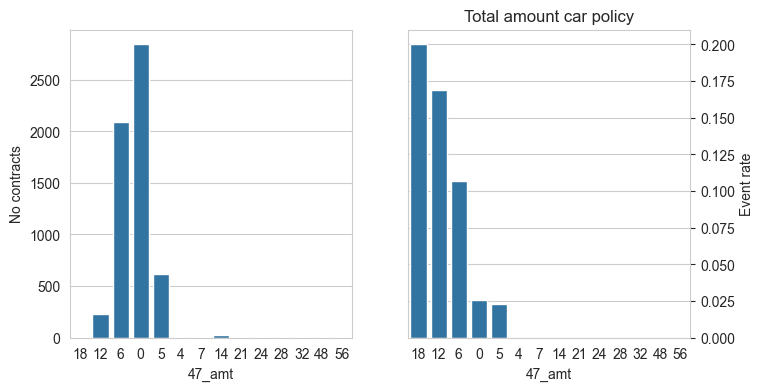

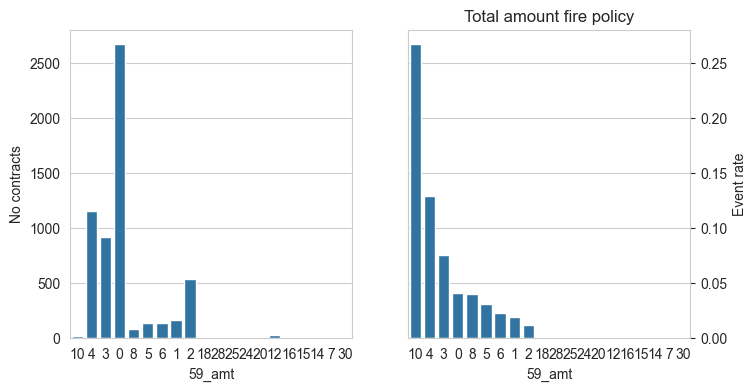

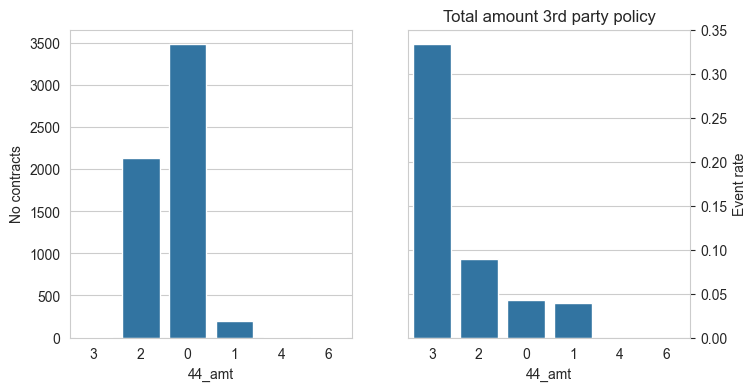

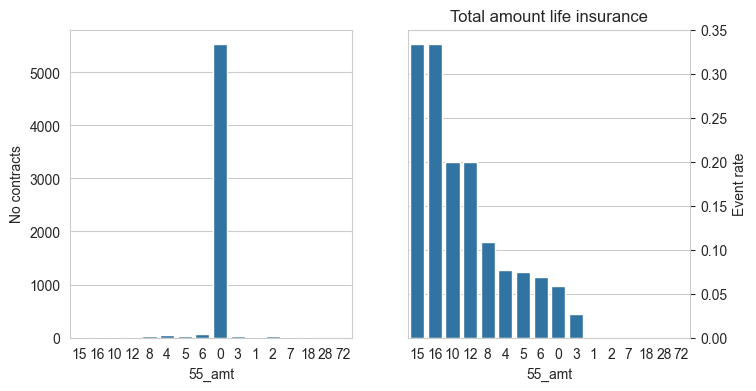

In [28]:
plot_stats('47_amt', label[0], df, title='Total amount car policy')
plot_stats('59_amt', label[0], df, title='Total amount fire policy')
plot_stats('44_amt', label[0], df, title='Total amount 3rd party policy')
plot_stats('55_amt', label[0], df, title='Total amount life insurance')

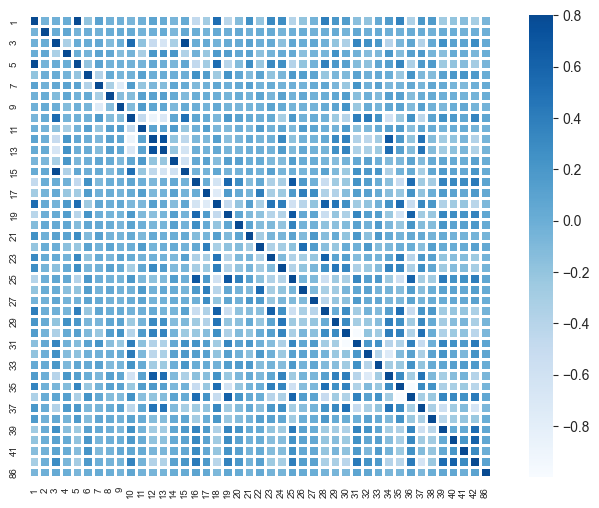

In [29]:
plot_corr_matrix(df[demo_feat+label])

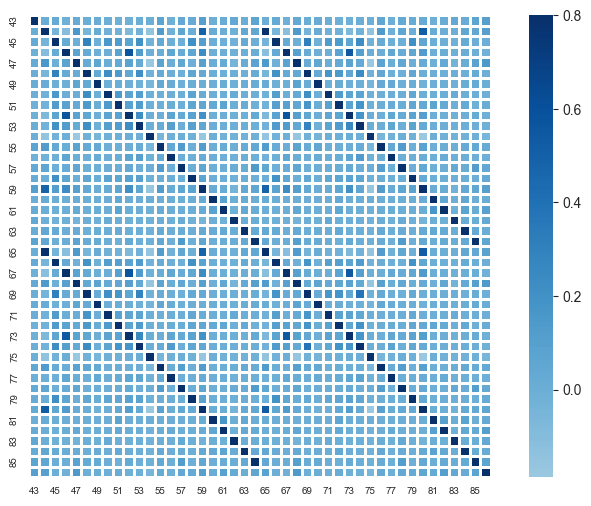

In [30]:
plot_corr_matrix(df[prod_own_feat+label])

# Feature selection

In [31]:
import optbinning
from optbinning import OptimalBinning
from sklearn.feature_selection import f_classif, chi2

In [32]:
feature_list_1 = list(set(df.columns) - set(['ID']+label) - set(drop_list))

In [33]:
len(feature_list_1)

77

In [34]:
df[feature_list_1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income_vs47       5822 non-null   float64
 1   14                5822 non-null   int64  
 2   4                 5822 non-null   int64  
 3   20                5822 non-null   int64  
 4   34                5822 non-null   int64  
 5   6                 5822 non-null   int64  
 6   17                5822 non-null   int64  
 7   10                5822 non-null   int64  
 8   income_vs55       5822 non-null   float64
 9   47_amt            5822 non-null   int64  
 10  64_amt            5822 non-null   int64  
 11  25                5822 non-null   int64  
 12  47                5822 non-null   int64  
 13  56_amt            5822 non-null   int64  
 14  total_all_policy  5822 non-null   int64  
 15  44                5822 non-null   int64  
 16  income_vs_policy  5822 non-null   float64


In [35]:
stat_table = feature_ranking(df, label[0], feature_list_1)

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:03<00:00, 23.81it/s]


In [36]:
stat_table.sort_values(by='iv', ascending=False)

,feature,iv,pval_test
65,total_con_level,0.847230,5.129102e-115
14,total_all_policy,0.732931,5.048541e-128
12,47,0.586539,8.797634e-85
9,47_amt,0.586539,4.640674e-112
0,income_vs47,0.501356,2.499469e-18
68,total_no_policy,0.437921,6.419584e-26
45,68,0.410574,7.021023e-19
16,income_vs_policy,0.359623,1.709150e-03
17,59,0.359368,1.288395e-23
52,59_amt,0.355700,4.213306e-20


In [37]:
filter_result = stat_table.query("iv > 0.02")\
            .query("pval_test <= 0.05|pval_test.isnull()")

In [38]:
feature_list_2 = list(filter_result['feature'])

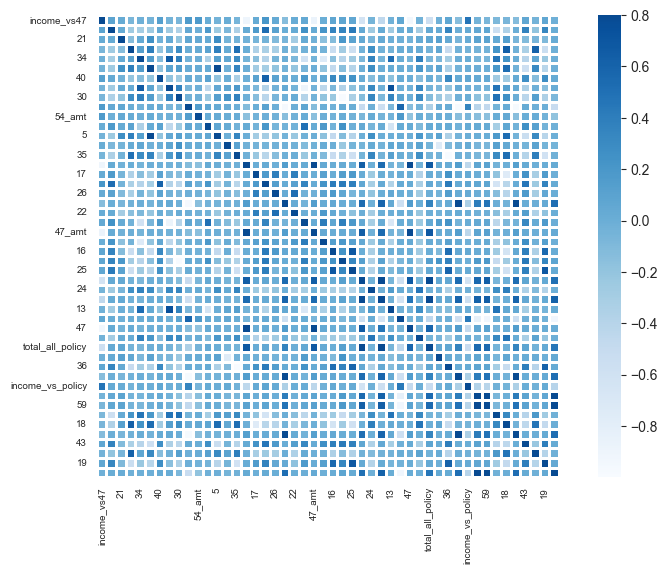

In [39]:
plot_corr_matrix(df[list(set(feature_list_2) - set(['social_class']))])

In [40]:
co = df[list(set(feature_list_2) - set(['social_class']))].corr().abs()

In [41]:
co_df = pd.DataFrame(co.unstack(), columns=['corr'])

In [42]:
co_df.query('corr > 0.8 & corr <1')

corr
income_vs47      68                0.898548
                 47_amt            0.875126
                 47                0.933146
1                5                 0.992672
12               10                0.884362
30               31                0.999554
income_vs44      44_amt            0.968048
                 44                0.973980
                 65                0.971437
5                1                 0.992672
35               36                0.999239
68               income_vs47       0.898548
                 47_amt            0.992464
                 47                0.916154
44_amt           income_vs44       0.968048
                 44                0.995538
                 65                0.980246
10               12                0.884362
47_amt           income_vs47       0.875126
                 68                0.992464
                 47                0.892514
31               30                0.999554
total_con_level  total_no_policy   0.911536
                 total_all_policy  0.899243
total_no_policy  total_con_level   0.911536
                 total_all_policy  0.918721
income_vs59      59_amt            0.820596
                 59                0.924455
                 80                0.927796
47               income_vs47       0.933146
                 68                0.916154
                 47_amt            0.892514
total_all_policy total_con_level   0.899243
                 total_no_policy   0.918721
36               35                0.999239
44               income_vs44       0.973980
                 44_amt            0.995538
                 65                0.981369
59_amt           income_vs59       0.820596
                 59                0.906280
                 80                0.906486
59               income_vs59       0.924455
                 59_amt            0.906280
                 80                0.865536
65               income_vs44       0.971437
                 44_amt            0.980246
                 44                0.981369
80               income_vs59       0.927796
                 59_amt            0.906486
                 59                0.865536

In [43]:
drop_list2 = ['total_con_level', 'total_all_policy',
              '59', 'income_vs59', '80'
              '1',
              '35', 
              '44', '65', 'income_vs44',
              '47', 'income_vs47', '68'
             '30']

In [44]:
len(drop_list2)

12

In [45]:
feature_list3 = list(set(feature_list_2)-set(drop_list2))

In [46]:
df[feature_list3].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   39                5822 non-null   int64  
 1   21                5822 non-null   int64  
 2   28                5822 non-null   int64  
 3   social_class      5822 non-null   int64  
 4   34                5822 non-null   int64  
 5   1                 5822 non-null   int64  
 6   40                5822 non-null   int64  
 7   12                5822 non-null   int64  
 8   30                5822 non-null   int64  
 9   54_amt            5822 non-null   int64  
 10  9                 5822 non-null   int64  
 11  15                5822 non-null   int64  
 12  5                 5822 non-null   int64  
 13  68                5822 non-null   int64  
 14  17                5822 non-null   int64  
 15  42                5822 non-null   int64  
 16  26                5822 non-null   int64  


# Training and evaluation

## Baseline model

In [47]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble  import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score

In [48]:
X = df[feature_list3]
y = df[label[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=1000)

In [ ]:
for i in [180, 190, 200, 210, 230, 250, 270, 290]:
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    accuracy = metrics.roc_auc_score(y_test, y_pred)
    print(f"N_estimator {i} - AUC: {accuracy}", )

In [ ]:
for i in [20, 50, 100, 200, 300, 500, 800, 1000]:
    clf = RandomForestClassifier(n_estimators = i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    accuracy = metrics.roc_auc_score(y_test, y_pred)
    print(f"N_estimator {i} - AUC: {accuracy}", )

In [51]:
clf = RandomForestClassifier(n_estimators = 220, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"Baseline model with AUC: {auc}")

Baseline model with AUC: 0.710084621302189


In [ ]:
import pickle
filename = 'models/RandomForestTrial-baseline.sav'
pickle.dump(clf, open(filename, 'wb'))

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

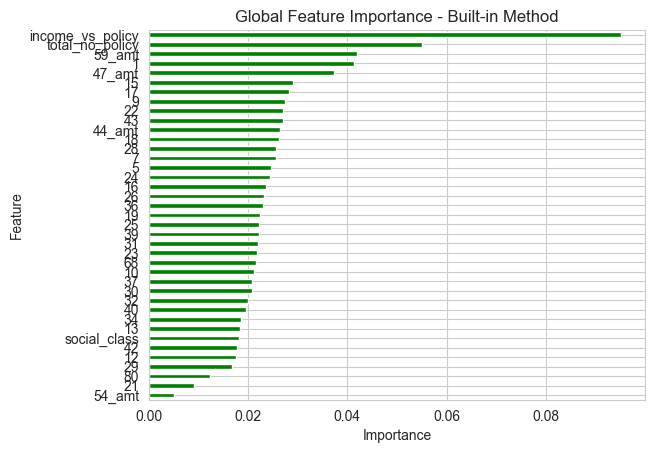

In [52]:
import matplotlib.pyplot as plt
global_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

## Boosting and hyperparameter tunning

In [53]:
from catboost import CatBoostClassifier
import optuna

In [58]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "iterations": trial.suggest_int("iterations", 100, 600),
        "l2_leaf_reg": trial.suggest_loguniform('l2_leaf_reg', 1, 100),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 300),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "bagging_temperature": trial.suggest_loguniform('bagging_temperature', 0.1, 20.0),
        "depth": trial.suggest_int("depth", 1, 6),
        "random_seed": 42
    }
    clf_fold = CatBoostClassifier(**params, silent=True)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = {'auc':[], 'recall':[]}
    class_threshold = trial.suggest_float("class_threshold", 0.01, 0.2)
    for train, test in kfold.split(df[feature_list3]):
        X_train_fold = df.loc[train][feature_list3]
        y_train_fold = df.loc[train][label[0]]
        X_test_fold = df.loc[test][feature_list3]
        y_test_fold = df.loc[test][label[0]]

        clf_fold.fit(X_train_fold, y_train_fold)
        y_pred_fold = clf_fold.predict_proba(X_test_fold)[:, 1]
        y_pred_class = [1 if i >= class_threshold else 0 for i in y_pred_fold]

        result = pd.DataFrame(y_test_fold).reset_index(drop=True)
        result['pred_class'] = y_pred_class
        result['pred_prob'] = y_pred_fold
        top_result = result.sort_values(by='pred_prob', ascending=False).iloc[:350]

        scores['auc'].append(metrics.roc_auc_score(y_test_fold, y_pred_fold))
        scores['recall'].append(metrics.recall_score(top_result[label[0]], top_result['pred_class']))

    final_auc = np.array(scores['auc']).mean()
    deviation = np.array(scores['auc']).std()
    recall = np.array(scores['recall']).mean()
        
    print("ROAUC: %0.2f , standard deviation: %0.6f, recall: %0.4f" % (final_auc, deviation, recall))
    return final_auc, deviation, recall

In [59]:
study = optuna.create_study(directions=['maximize', 'minimize', 'maximize'], sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

[I 2024-03-17 00:36:34,654] A new study created in memory with name: no-name-d19c00ad-dc23-430b-967d-b98b317090cd
[I 2024-03-17 00:36:44,596] Trial 0 finished with values: [0.751323142212674, 0.023197100783299805, 1.0] and parameters: {'learning_rate': 0.005339890116237239, 'iterations': 545, 'l2_leaf_reg': 37.24538323692971, 'min_data_in_leaf': 204, 'subsample': 0.6966868535683874, 'colsample_bylevel': 0.38067809014863074, 'bagging_temperature': 15.537002300794112, 'depth': 1, 'class_threshold': 0.012924128749520274}. 


ROAUC: 0.75 , standard deviation: 0.023197, recall: 1.0000


[I 2024-03-17 00:36:53,634] Trial 1 finished with values: [0.7526831808091482, 0.023274047392307137, 1.0] and parameters: {'learning_rate': 0.01373140031082184, 'iterations': 481, 'l2_leaf_reg': 15.634953076543338, 'min_data_in_leaf': 195, 'subsample': 0.1575594398396194, 'colsample_bylevel': 0.09390404412538689, 'bagging_temperature': 0.33891491122206446, 'depth': 2, 'class_threshold': 0.011274454080373825}. 


ROAUC: 0.75 , standard deviation: 0.023274, recall: 1.0000


[I 2024-03-17 00:37:13,838] Trial 2 finished with values: [0.764991619977649, 0.013551386107739342, 0.45653036992210955] and parameters: {'learning_rate': 0.018479973665419383, 'iterations': 557, 'l2_leaf_reg': 3.5627726641179387, 'min_data_in_leaf': 44, 'subsample': 0.8944063145969118, 'colsample_bylevel': 0.7732975990601076, 'bagging_temperature': 2.767370303536151, 'depth': 6, 'class_threshold': 0.13952536633978235}. 


ROAUC: 0.76 , standard deviation: 0.013551, recall: 0.4565


[I 2024-03-17 00:37:26,779] Trial 3 finished with values: [0.7493372901681142, 0.022297095281349183, 0.479671793150054] and parameters: {'learning_rate': 0.0057371230562652, 'iterations': 508, 'l2_leaf_reg': 51.2501220405818, 'min_data_in_leaf': 95, 'subsample': 0.5814724701157696, 'colsample_bylevel': 0.5285023715893804, 'bagging_temperature': 1.080550097458986, 'depth': 4, 'class_threshold': 0.13100048843045672}. 


ROAUC: 0.75 , standard deviation: 0.022297, recall: 0.4797


[I 2024-03-17 00:37:36,614] Trial 4 finished with values: [0.7615699784728547, 0.019909971171037703, 0.3226839574947059] and parameters: {'learning_rate': 0.013970516074841479, 'iterations': 490, 'l2_leaf_reg': 10.21000354505235, 'min_data_in_leaf': 236, 'subsample': 0.5112071628547432, 'colsample_bylevel': 0.48195586084839165, 'bagging_temperature': 1.997746779688327, 'depth': 2, 'class_threshold': 0.17493480178527124}. 


ROAUC: 0.76 , standard deviation: 0.019910, recall: 0.3227


[I 2024-03-17 00:37:45,064] Trial 5 finished with values: [0.7685104644378544, 0.013333669921377985, 0.38596348483108067] and parameters: {'learning_rate': 0.028572640821144506, 'iterations': 322, 'l2_leaf_reg': 22.356715272717487, 'min_data_in_leaf': 55, 'subsample': 0.6857809770092327, 'colsample_bylevel': 0.48971175079474394, 'bagging_temperature': 5.080895757451598, 'depth': 4, 'class_threshold': 0.16871512792815957}. 


ROAUC: 0.77 , standard deviation: 0.013334, recall: 0.3860


[I 2024-03-17 00:37:55,803] Trial 6 finished with values: [0.7630155723618955, 0.01754455371263066, 1.0] and parameters: {'learning_rate': 0.02090698314821843, 'iterations': 392, 'l2_leaf_reg': 1.010636065191756, 'min_data_in_leaf': 288, 'subsample': 0.8167500965006771, 'colsample_bylevel': 0.1702446443528845, 'bagging_temperature': 4.893077736812587, 'depth': 5, 'class_threshold': 0.02093252720172005}. 


ROAUC: 0.76 , standard deviation: 0.017545, recall: 1.0000


[I 2024-03-17 00:38:03,090] Trial 7 finished with values: [0.7518028721647149, 0.024713206905667747, 0.0] and parameters: {'learning_rate': 0.006905280329664831, 'iterations': 441, 'l2_leaf_reg': 14.464019436435391, 'min_data_in_leaf': 154, 'subsample': 0.1140320177782065, 'colsample_bylevel': 0.5537047101851437, 'bagging_temperature': 0.7043197306377509, 'depth': 1, 'class_threshold': 0.1816056546063449}. 


ROAUC: 0.75 , standard deviation: 0.024713, recall: 0.0000


[I 2024-03-17 00:38:08,978] Trial 8 finished with values: [0.7434874626836903, 0.031117497530597345, 0.674512230911913] and parameters: {'learning_rate': 0.003191981568977234, 'iterations': 357, 'l2_leaf_reg': 1.2750894925213374, 'min_data_in_leaf': 224, 'subsample': 0.463591996341791, 'colsample_bylevel': 0.3122486419220864, 'bagging_temperature': 8.804803216402728, 'depth': 1, 'class_threshold': 0.14284044596609138}. 


ROAUC: 0.74 , standard deviation: 0.031117, recall: 0.6745


[I 2024-03-17 00:38:16,504] Trial 9 finished with values: [0.7318598156484615, 0.03381014943294631, 1.0] and parameters: {'learning_rate': 0.0016852424691987443, 'iterations': 327, 'l2_leaf_reg': 5.785960924200295, 'min_data_in_leaf': 265, 'subsample': 0.5776945067099258, 'colsample_bylevel': 0.7372703715962167, 'bagging_temperature': 0.1967126423615796, 'depth': 3, 'class_threshold': 0.15180064851669073}. 


ROAUC: 0.73 , standard deviation: 0.033810, recall: 1.0000


[I 2024-03-17 00:38:19,975] Trial 10 finished with values: [0.7471086049308227, 0.03384647972019118, 0.9007033850588293] and parameters: {'learning_rate': 0.0954116202543561, 'iterations': 123, 'l2_leaf_reg': 1.0408237022390936, 'min_data_in_leaf': 297, 'subsample': 0.9995396324732747, 'colsample_bylevel': 0.07140249139176669, 'bagging_temperature': 17.932035836168374, 'depth': 6, 'class_threshold': 0.06629576651824973}. 


ROAUC: 0.75 , standard deviation: 0.033846, recall: 0.9007


[I 2024-03-17 00:38:26,617] Trial 11 finished with values: [0.7590488100568844, 0.01648145489971512, 0.8403855428350202] and parameters: {'learning_rate': 0.04030586458478392, 'iterations': 193, 'l2_leaf_reg': 2.914524794240664, 'min_data_in_leaf': 10, 'subsample': 0.9390273532689295, 'colsample_bylevel': 0.8642919937567828, 'bagging_temperature': 3.2422448013465552, 'depth': 6, 'class_threshold': 0.07813657803095758}. 


ROAUC: 0.76 , standard deviation: 0.016481, recall: 0.8404


[I 2024-03-17 00:38:32,716] Trial 12 finished with values: [0.7526238610975994, 0.01977903884119798, 0.7579276046381309] and parameters: {'learning_rate': 0.05886645876806154, 'iterations': 181, 'l2_leaf_reg': 3.3835737920543467, 'min_data_in_leaf': 1, 'subsample': 0.9932117983893262, 'colsample_bylevel': 0.9533753953046038, 'bagging_temperature': 2.312949971896437, 'depth': 6, 'class_threshold': 0.08617298417283836}. 


ROAUC: 0.75 , standard deviation: 0.019779, recall: 0.7579


[I 2024-03-17 00:38:39,708] Trial 13 finished with values: [0.7662035261976965, 0.014702935516485162, 1.0] and parameters: {'learning_rate': 0.0438429479250513, 'iterations': 237, 'l2_leaf_reg': 2.9053367495236486, 'min_data_in_leaf': 6, 'subsample': 0.8622667394091386, 'colsample_bylevel': 0.967224167002979, 'bagging_temperature': 4.039737793017028, 'depth': 5, 'class_threshold': 0.05760970589410658}. 


ROAUC: 0.77 , standard deviation: 0.014703, recall: 1.0000


[I 2024-03-17 00:38:46,856] Trial 14 finished with values: [0.7549724841422443, 0.022062397413193862, 1.0] and parameters: {'learning_rate': 0.09249788307301707, 'iterations': 252, 'l2_leaf_reg': 2.597894510169477, 'min_data_in_leaf': 63, 'subsample': 0.34767335398819876, 'colsample_bylevel': 0.7674750439479892, 'bagging_temperature': 0.6542781344560611, 'depth': 5, 'class_threshold': 0.04795226089333232}. 


ROAUC: 0.75 , standard deviation: 0.022062, recall: 1.0000


[I 2024-03-17 00:38:54,857] Trial 15 finished with values: [0.7660367259642226, 0.010902426281377614, 0.6163429545500247] and parameters: {'learning_rate': 0.04378716659830965, 'iterations': 265, 'l2_leaf_reg': 5.4394749824263595, 'min_data_in_leaf': 46, 'subsample': 0.8362210960476477, 'colsample_bylevel': 0.994386443671825, 'bagging_temperature': 7.732532557651258, 'depth': 5, 'class_threshold': 0.11527998981823638}. 


ROAUC: 0.77 , standard deviation: 0.010902, recall: 0.6163


[I 2024-03-17 00:39:02,323] Trial 16 finished with values: [0.7664441461741527, 0.013768990539598088, 0.63406642023118] and parameters: {'learning_rate': 0.04540787303063757, 'iterations': 257, 'l2_leaf_reg': 6.342563953401406, 'min_data_in_leaf': 125, 'subsample': 0.7731927212881625, 'colsample_bylevel': 0.994617121627618, 'bagging_temperature': 0.103783423649003, 'depth': 5, 'class_threshold': 0.1064046929994333}. 


ROAUC: 0.77 , standard deviation: 0.013769, recall: 0.6341


[I 2024-03-17 00:39:09,356] Trial 17 finished with values: [0.7012536809166624, 0.03130694820995501, 1.0] and parameters: {'learning_rate': 0.0011250932901664661, 'iterations': 267, 'l2_leaf_reg': 90.35124977290135, 'min_data_in_leaf': 29, 'subsample': 0.839922669140831, 'colsample_bylevel': 0.6321822053214923, 'bagging_temperature': 8.262570402966805, 'depth': 4, 'class_threshold': 0.04551070734612111}. 


ROAUC: 0.70 , standard deviation: 0.031307, recall: 1.0000


[I 2024-03-17 00:39:13,612] Trial 18 finished with values: [0.7618978535478677, 0.013660636503289622, 0.5865627172854958] and parameters: {'learning_rate': 0.030684770593400364, 'iterations': 138, 'l2_leaf_reg': 2.2181265079901324, 'min_data_in_leaf': 90, 'subsample': 0.7402325962320355, 'colsample_bylevel': 0.8582779162448104, 'bagging_temperature': 8.060931294310981, 'depth': 5, 'class_threshold': 0.1163025751872985}. 


ROAUC: 0.76 , standard deviation: 0.013661, recall: 0.5866


[I 2024-03-17 00:39:18,277] Trial 19 finished with values: [0.7684990806235736, 0.012491687511411617, 1.0] and parameters: {'learning_rate': 0.05879971867822701, 'iterations': 206, 'l2_leaf_reg': 5.411417562731567, 'min_data_in_leaf': 81, 'subsample': 0.29728945306410703, 'colsample_bylevel': 0.6806811900747678, 'bagging_temperature': 1.0594875606991954, 'depth': 3, 'class_threshold': 0.04473947301671152}. 


ROAUC: 0.77 , standard deviation: 0.012492, recall: 1.0000


[I 2024-03-17 00:39:20,725] Trial 20 finished with values: [0.7585515223106226, 0.021064313795324887, 0.2361973251334953] and parameters: {'learning_rate': 0.06568332139617755, 'iterations': 100, 'l2_leaf_reg': 5.710875660869766, 'min_data_in_leaf': 145, 'subsample': 0.26497140919919454, 'colsample_bylevel': 0.6200634131383123, 'bagging_temperature': 1.3048280067287106, 'depth': 3, 'class_threshold': 0.1990044185622683}. 


ROAUC: 0.76 , standard deviation: 0.021064, recall: 0.2362


[I 2024-03-17 00:39:27,487] Trial 21 finished with values: [0.7670529670036661, 0.015260874039120425, 0.7299753397946895] and parameters: {'learning_rate': 0.027623095919210746, 'iterations': 314, 'l2_leaf_reg': 21.51015148872442, 'min_data_in_leaf': 81, 'subsample': 0.30538811242232256, 'colsample_bylevel': 0.36793920341078556, 'bagging_temperature': 0.4925749017838478, 'depth': 3, 'class_threshold': 0.09319294920743532}. 


ROAUC: 0.77 , standard deviation: 0.015261, recall: 0.7300


[I 2024-03-17 00:39:31,385] Trial 22 finished with values: [0.7659753446859985, 0.014617520020263406, 1.0] and parameters: {'learning_rate': 0.058659875038921463, 'iterations': 186, 'l2_leaf_reg': 8.531873452407686, 'min_data_in_leaf': 117, 'subsample': 0.40716245713229166, 'colsample_bylevel': 0.6946927052307398, 'bagging_temperature': 1.2049615455296359, 'depth': 2, 'class_threshold': 0.036874472588360976}. 


ROAUC: 0.77 , standard deviation: 0.014618, recall: 1.0000


[I 2024-03-17 00:39:36,618] Trial 23 finished with values: [0.7609379235232077, 0.019402652898602248, 1.0] and parameters: {'learning_rate': 0.026848870237952672, 'iterations': 212, 'l2_leaf_reg': 1.6724216205123894, 'min_data_in_leaf': 59, 'subsample': 0.22171893798486958, 'colsample_bylevel': 0.8603116364507977, 'bagging_temperature': 0.32955608013473353, 'depth': 4, 'class_threshold': 0.029934244396232695}. 


ROAUC: 0.76 , standard deviation: 0.019403, recall: 1.0000


[I 2024-03-17 00:39:42,843] Trial 24 finished with values: [0.7635649647297861, 0.018680768908581124, 0.9131281592151158] and parameters: {'learning_rate': 0.07450273168685552, 'iterations': 299, 'l2_leaf_reg': 4.736389533414776, 'min_data_in_leaf': 164, 'subsample': 0.05805334309954391, 'colsample_bylevel': 0.2595651040995133, 'bagging_temperature': 1.6398122601236447, 'depth': 3, 'class_threshold': 0.0717344093066325}. 


ROAUC: 0.76 , standard deviation: 0.018681, recall: 0.9131


[I 2024-03-17 00:39:47,254] Trial 25 finished with values: [0.7559056041956451, 0.017012659095049412, 0.5738605384385436] and parameters: {'learning_rate': 0.03681854824601725, 'iterations': 168, 'l2_leaf_reg': 9.588962090932505, 'min_data_in_leaf': 35, 'subsample': 0.6433595759784967, 'colsample_bylevel': 0.4517299817061033, 'bagging_temperature': 0.7295703865243451, 'depth': 4, 'class_threshold': 0.12228867962513333}. 


ROAUC: 0.76 , standard deviation: 0.017013, recall: 0.5739


[I 2024-03-17 00:39:54,984] Trial 26 finished with values: [0.7539325511136282, 0.024398197707986704, 0.6899828775343649] and parameters: {'learning_rate': 0.009968186015282973, 'iterations': 380, 'l2_leaf_reg': 28.076462325053978, 'min_data_in_leaf': 109, 'subsample': 0.40918532231815163, 'colsample_bylevel': 0.6123900620395573, 'bagging_temperature': 6.025527029774217, 'depth': 2, 'class_threshold': 0.1029628104198827}. 


ROAUC: 0.75 , standard deviation: 0.024398, recall: 0.6900


[I 2024-03-17 00:40:07,601] Trial 27 finished with values: [0.7658008792874609, 0.014835840478700521, 1.0] and parameters: {'learning_rate': 0.02132357448638865, 'iterations': 596, 'l2_leaf_reg': 4.213356755432599, 'min_data_in_leaf': 70, 'subsample': 0.23429923185221013, 'colsample_bylevel': 0.6961435296312429, 'bagging_temperature': 10.962209783925587, 'depth': 3, 'class_threshold': 0.057713117547800064}. 


ROAUC: 0.77 , standard deviation: 0.014836, recall: 1.0000


[I 2024-03-17 00:40:14,802] Trial 28 finished with values: [0.7692729018508527, 0.014813688944419357, 0.424876254180602] and parameters: {'learning_rate': 0.05417022344058673, 'iterations': 295, 'l2_leaf_reg': 7.741623521811242, 'min_data_in_leaf': 135, 'subsample': 0.35924582481379486, 'colsample_bylevel': 0.9003444210952356, 'bagging_temperature': 0.14754849746711354, 'depth': 4, 'class_threshold': 0.16212329395821332}. 


ROAUC: 0.77 , standard deviation: 0.014814, recall: 0.4249


[I 2024-03-17 00:40:19,504] Trial 29 finished with values: [0.740574587599452, 0.02266983834839291, 1.0] and parameters: {'learning_rate': 0.004339362743394172, 'iterations': 222, 'l2_leaf_reg': 12.648248639537824, 'min_data_in_leaf': 137, 'subsample': 0.341088203006607, 'colsample_bylevel': 0.8175709093770929, 'bagging_temperature': 0.11655174297052594, 'depth': 2, 'class_threshold': 0.02945918630592933}. 


ROAUC: 0.74 , standard deviation: 0.022670, recall: 1.0000


[I 2024-03-17 00:40:24,422] Trial 30 finished with values: [0.73293596873199, 0.030457702096787918, 1.0] and parameters: {'learning_rate': 0.002397366110687268, 'iterations': 277, 'l2_leaf_reg': 7.252752876068414, 'min_data_in_leaf': 165, 'subsample': 0.16193184866368093, 'colsample_bylevel': 0.9152103707479332, 'bagging_temperature': 0.21197732555108328, 'depth': 1, 'class_threshold': 0.09117663333116865}. 


ROAUC: 0.73 , standard deviation: 0.030458, recall: 1.0000


[I 2024-03-17 00:40:28,332] Trial 31 finished with values: [0.7646922162630141, 0.017380380557441292, 0.6555944986690327] and parameters: {'learning_rate': 0.05234391746190104, 'iterations': 147, 'l2_leaf_reg': 1.8008776925347525, 'min_data_in_leaf': 48, 'subsample': 0.6862444148789701, 'colsample_bylevel': 0.3888878875051974, 'bagging_temperature': 12.801229941753695, 'depth': 4, 'class_threshold': 0.10856329857876293}. 


ROAUC: 0.76 , standard deviation: 0.017380, recall: 0.6556


[I 2024-03-17 00:40:37,635] Trial 32 finished with values: [0.7683021060286416, 0.010163403160475638, 1.0] and parameters: {'learning_rate': 0.06913512656243882, 'iterations': 435, 'l2_leaf_reg': 19.786472769799296, 'min_data_in_leaf': 101, 'subsample': 0.17555489572338587, 'colsample_bylevel': 0.7034439314014617, 'bagging_temperature': 0.40455194965114805, 'depth': 3, 'class_threshold': 0.01117003763960988}. 


ROAUC: 0.77 , standard deviation: 0.010163, recall: 1.0000


[I 2024-03-17 00:40:46,650] Trial 33 finished with values: [0.7676893022368251, 0.012752585168603428, 1.0] and parameters: {'learning_rate': 0.0996256735514716, 'iterations': 425, 'l2_leaf_reg': 39.5547423527388, 'min_data_in_leaf': 183, 'subsample': 0.054357544029635135, 'colsample_bylevel': 0.6690803268323164, 'bagging_temperature': 0.33841434428569855, 'depth': 3, 'class_threshold': 0.013491043957486924}. 


ROAUC: 0.77 , standard deviation: 0.012753, recall: 1.0000


[I 2024-03-17 00:40:55,594] Trial 34 finished with values: [0.7704410218476166, 0.008847862802480731, 1.0] and parameters: {'learning_rate': 0.07756474795945033, 'iterations': 458, 'l2_leaf_reg': 21.259981020767228, 'min_data_in_leaf': 104, 'subsample': 0.16059286579733908, 'colsample_bylevel': 0.5675096780581288, 'bagging_temperature': 0.20276442528635116, 'depth': 2, 'class_threshold': 0.010957766175685538}. 


ROAUC: 0.77 , standard deviation: 0.008848, recall: 1.0000


[I 2024-03-17 00:41:05,787] Trial 35 finished with values: [0.7688386943298899, 0.010399510199406548, 1.0] and parameters: {'learning_rate': 0.07175717251906621, 'iterations': 523, 'l2_leaf_reg': 62.503539657705154, 'min_data_in_leaf': 102, 'subsample': 0.1680620834504905, 'colsample_bylevel': 0.5383648156540229, 'bagging_temperature': 0.17904877395931948, 'depth': 2, 'class_threshold': 0.01171046567564402}. 


ROAUC: 0.77 , standard deviation: 0.010400, recall: 1.0000


[I 2024-03-17 00:41:16,030] Trial 36 finished with values: [0.7687156912413899, 0.00994499053871276, 1.0] and parameters: {'learning_rate': 0.07175951626853935, 'iterations': 524, 'l2_leaf_reg': 67.70279768791241, 'min_data_in_leaf': 203, 'subsample': 0.16948744010203162, 'colsample_bylevel': 0.5600539124953868, 'bagging_temperature': 0.16208873103863003, 'depth': 2, 'class_threshold': 0.015586786422680339}. 


ROAUC: 0.77 , standard deviation: 0.009945, recall: 1.0000


[I 2024-03-17 00:41:26,106] Trial 37 finished with values: [0.7552998783416912, 0.022676888189145424, 1.0] and parameters: {'learning_rate': 0.012572046167711341, 'iterations': 528, 'l2_leaf_reg': 60.82416789068723, 'min_data_in_leaf': 129, 'subsample': 0.184392364604349, 'colsample_bylevel': 0.1531802234321618, 'bagging_temperature': 0.17024219070064497, 'depth': 2, 'class_threshold': 0.021989707599502754}. 


ROAUC: 0.76 , standard deviation: 0.022677, recall: 1.0000


[I 2024-03-17 00:41:34,194] Trial 38 finished with values: [0.7683726698241561, 0.014137444400934516, 1.0] and parameters: {'learning_rate': 0.08220444275202077, 'iterations': 477, 'l2_leaf_reg': 32.733594589064296, 'min_data_in_leaf': 203, 'subsample': 0.11326859944964685, 'colsample_bylevel': 0.2188679476035072, 'bagging_temperature': 0.1520171526392548, 'depth': 1, 'class_threshold': 0.02390737088486187}. 


ROAUC: 0.77 , standard deviation: 0.014137, recall: 1.0000


[I 2024-03-17 00:41:45,105] Trial 39 finished with values: [0.7521404755765451, 0.022512282354529883, 1.0] and parameters: {'learning_rate': 0.008559420079243974, 'iterations': 563, 'l2_leaf_reg': 96.6009859156643, 'min_data_in_leaf': 236, 'subsample': 0.09710118121961205, 'colsample_bylevel': 0.5682809004448968, 'bagging_temperature': 0.25766182696283063, 'depth': 2, 'class_threshold': 0.03783215676290789}. 


ROAUC: 0.75 , standard deviation: 0.022512, recall: 1.0000


[I 2024-03-17 00:41:53,098] Trial 40 finished with values: [0.7554278422941567, 0.022667601737925015, 1.0] and parameters: {'learning_rate': 0.015601744786559237, 'iterations': 457, 'l2_leaf_reg': 54.02398111838779, 'min_data_in_leaf': 180, 'subsample': 0.2555684442273201, 'colsample_bylevel': 0.43129564675378207, 'bagging_temperature': 0.8721999551824122, 'depth': 1, 'class_threshold': 0.014621583166389292}. 


ROAUC: 0.76 , standard deviation: 0.022668, recall: 1.0000


[I 2024-03-17 00:42:01,185] Trial 41 finished with values: [0.767208190919219, 0.009938526877878561, 1.0] and parameters: {'learning_rate': 0.07324418433283317, 'iterations': 411, 'l2_leaf_reg': 18.945393988036926, 'min_data_in_leaf': 101, 'subsample': 0.19275008001065413, 'colsample_bylevel': 0.4816288535060574, 'bagging_temperature': 0.43875122016022905, 'depth': 2, 'class_threshold': 0.014749673659875104}. 


ROAUC: 0.77 , standard deviation: 0.009939, recall: 1.0000


[I 2024-03-17 00:42:10,559] Trial 42 finished with values: [0.7270528262186252, 0.03468967543214182, 1.0] and parameters: {'learning_rate': 0.0017656356789870092, 'iterations': 493, 'l2_leaf_reg': 16.414675843314456, 'min_data_in_leaf': 106, 'subsample': 0.1970139852960558, 'colsample_bylevel': 0.15162179658316, 'bagging_temperature': 0.24835725848899923, 'depth': 2, 'class_threshold': 0.011147000235204318}. 


ROAUC: 0.73 , standard deviation: 0.034690, recall: 1.0000


[I 2024-03-17 00:42:18,513] Trial 43 finished with values: [0.7489877550745649, 0.023880698099518136, 0.027627627627627625] and parameters: {'learning_rate': 0.0046881765084679635, 'iterations': 420, 'l2_leaf_reg': 11.970540355426012, 'min_data_in_leaf': 220, 'subsample': 0.127407858524562, 'colsample_bylevel': 0.30211854426635665, 'bagging_temperature': 0.14320688615200838, 'depth': 2, 'class_threshold': 0.16219991693900154}. 


ROAUC: 0.75 , standard deviation: 0.023881, recall: 0.0276


[I 2024-03-17 00:42:26,250] Trial 44 finished with values: [0.7656622426604904, 0.01216993613956446, 1.0] and parameters: {'learning_rate': 0.07406221447107703, 'iterations': 395, 'l2_leaf_reg': 41.707195372799696, 'min_data_in_leaf': 268, 'subsample': 0.1453877560645968, 'colsample_bylevel': 0.48599318685731124, 'bagging_temperature': 0.2659446818026109, 'depth': 2, 'class_threshold': 0.031132181774072364}. 


ROAUC: 0.77 , standard deviation: 0.012170, recall: 1.0000


[I 2024-03-17 00:42:34,557] Trial 45 finished with values: [0.7701094742902732, 0.010992859977014718, 1.0] and parameters: {'learning_rate': 0.05182017976653417, 'iterations': 469, 'l2_leaf_reg': 27.104059358499235, 'min_data_in_leaf': 84, 'subsample': 0.5408911808365209, 'colsample_bylevel': 0.5323817184964443, 'bagging_temperature': 0.457075520045544, 'depth': 1, 'class_threshold': 0.019348888285090605}. 


ROAUC: 0.77 , standard deviation: 0.010993, recall: 1.0000


[I 2024-03-17 00:42:43,535] Trial 46 finished with values: [0.7529860623451621, 0.02353427516658868, 1.0] and parameters: {'learning_rate': 0.00690445513826495, 'iterations': 521, 'l2_leaf_reg': 27.90269877857705, 'min_data_in_leaf': 83, 'subsample': 0.5958631973784155, 'colsample_bylevel': 0.5578091638129382, 'bagging_temperature': 0.20391533594248137, 'depth': 1, 'class_threshold': 0.02127530054165233}. 


ROAUC: 0.75 , standard deviation: 0.023534, recall: 1.0000


[I 2024-03-17 00:42:51,549] Trial 47 finished with values: [0.7689604579381845, 0.013898096520729054, 0.26912838714080956] and parameters: {'learning_rate': 0.0335796896433388, 'iterations': 465, 'l2_leaf_reg': 16.109344210045712, 'min_data_in_leaf': 118, 'subsample': 0.5396167380840233, 'colsample_bylevel': 0.5056167745535923, 'bagging_temperature': 0.12433782213953871, 'depth': 1, 'class_threshold': 0.1930873031039918}. 


ROAUC: 0.77 , standard deviation: 0.013898, recall: 0.2691


[I 2024-03-17 00:42:59,202] Trial 48 finished with values: [0.7638354589342026, 0.01792229960920654, 0.47972247011190217] and parameters: {'learning_rate': 0.02230907079576037, 'iterations': 369, 'l2_leaf_reg': 29.146521156048546, 'min_data_in_leaf': 266, 'subsample': 0.48800210915522546, 'colsample_bylevel': 0.5535066614819695, 'bagging_temperature': 0.43632067331541413, 'depth': 2, 'class_threshold': 0.13642388527776791}. 


ROAUC: 0.76 , standard deviation: 0.017922, recall: 0.4797


[I 2024-03-17 00:43:06,181] Trial 49 finished with values: [0.7597034078659506, 0.016283199811137235, 1.0] and parameters: {'learning_rate': 0.08291531448116518, 'iterations': 400, 'l2_leaf_reg': 19.72666376623805, 'min_data_in_leaf': 27, 'subsample': 0.08459444924099513, 'colsample_bylevel': 0.42507880216752697, 'bagging_temperature': 0.6045212631448761, 'depth': 1, 'class_threshold': 0.05515837338776296}. 


ROAUC: 0.76 , standard deviation: 0.016283, recall: 1.0000


[I 2024-03-17 00:43:13,322] Trial 50 finished with values: [0.7134054946447522, 0.03434583138986412, 1.0] and parameters: {'learning_rate': 0.0011345799701727604, 'iterations': 342, 'l2_leaf_reg': 66.44068914212296, 'min_data_in_leaf': 150, 'subsample': 0.20676391092637914, 'colsample_bylevel': 0.587007895343024, 'bagging_temperature': 0.2935747653979842, 'depth': 2, 'class_threshold': 0.03498922787069321}. 


ROAUC: 0.71 , standard deviation: 0.034346, recall: 1.0000


[I 2024-03-17 00:43:26,416] Trial 51 finished with values: [0.754419052762212, 0.019635236394742284, 1.0] and parameters: {'learning_rate': 0.06965297777504376, 'iterations': 437, 'l2_leaf_reg': 20.49269396113616, 'min_data_in_leaf': 99, 'subsample': 0.17359532334774846, 'colsample_bylevel': 0.5287161475902683, 'bagging_temperature': 0.18942703877360886, 'depth': 6, 'class_threshold': 0.011426593983051172}. 


ROAUC: 0.75 , standard deviation: 0.019635, recall: 1.0000


[I 2024-03-17 00:43:37,636] Trial 52 finished with values: [0.7683861487586243, 0.011790051814905403, 1.0] and parameters: {'learning_rate': 0.04819719898505298, 'iterations': 507, 'l2_leaf_reg': 23.67572412328304, 'min_data_in_leaf': 71, 'subsample': 0.28198144655725116, 'colsample_bylevel': 0.7418563492206911, 'bagging_temperature': 0.4014508654373758, 'depth': 3, 'class_threshold': 0.02028042034418973}. 


ROAUC: 0.77 , standard deviation: 0.011790, recall: 1.0000


[I 2024-03-17 00:43:47,417] Trial 53 finished with values: [0.7702672240230755, 0.012454921299258685, 0.35831539909589305] and parameters: {'learning_rate': 0.09641612968103062, 'iterations': 554, 'l2_leaf_reg': 17.85053425639853, 'min_data_in_leaf': 113, 'subsample': 0.1627796975414167, 'colsample_bylevel': 0.6548884086053792, 'bagging_temperature': 19.372696400237537, 'depth': 1, 'class_threshold': 0.18148764247954663}. 


ROAUC: 0.77 , standard deviation: 0.012455, recall: 0.3583


[I 2024-03-17 00:43:57,483] Trial 54 finished with values: [0.7482285889099571, 0.02395646193264218, 0.0] and parameters: {'learning_rate': 0.0031851333334948144, 'iterations': 550, 'l2_leaf_reg': 13.839231590093487, 'min_data_in_leaf': 93, 'subsample': 0.8922004432485646, 'colsample_bylevel': 0.631732996233287, 'bagging_temperature': 0.10000769310046234, 'depth': 1, 'class_threshold': 0.14605944722657402}. 


ROAUC: 0.75 , standard deviation: 0.023956, recall: 0.0000


[I 2024-03-17 00:44:05,710] Trial 55 finished with values: [0.7649312187344082, 0.013480421573200908, 1.0] and parameters: {'learning_rate': 0.08326746462640247, 'iterations': 454, 'l2_leaf_reg': 11.011351252797253, 'min_data_in_leaf': 281, 'subsample': 0.9612001293478813, 'colsample_bylevel': 0.050087372132324004, 'bagging_temperature': 2.6902728231434607, 'depth': 2, 'class_threshold': 0.04142355231877933}. 


ROAUC: 0.76 , standard deviation: 0.013480, recall: 1.0000


[I 2024-03-17 00:44:18,284] Trial 56 finished with values: [0.7513952879556444, 0.02051820730374714, 1.0] and parameters: {'learning_rate': 0.09968112787780457, 'iterations': 411, 'l2_leaf_reg': 34.160783683330784, 'min_data_in_leaf': 117, 'subsample': 0.7524215936163798, 'colsample_bylevel': 0.5221659587110952, 'bagging_temperature': 0.5538991503014629, 'depth': 6, 'class_threshold': 0.02757309695717161}. 


ROAUC: 0.75 , standard deviation: 0.020518, recall: 1.0000


[I 2024-03-17 00:44:26,915] Trial 57 finished with values: [0.7659517277520693, 0.014913850146282236, 0.34549759966001703] and parameters: {'learning_rate': 0.04302828444762074, 'iterations': 482, 'l2_leaf_reg': 17.83736868475944, 'min_data_in_leaf': 239, 'subsample': 0.14768486203624515, 'colsample_bylevel': 0.11159634889122744, 'bagging_temperature': 3.8703273706093757, 'depth': 2, 'class_threshold': 0.18188087949223136}. 


ROAUC: 0.77 , standard deviation: 0.014914, recall: 0.3455


[I 2024-03-17 00:44:38,514] Trial 58 finished with values: [0.7672191217017538, 0.014655570964738322, 1.0] and parameters: {'learning_rate': 0.062203286343775664, 'iterations': 572, 'l2_leaf_reg': 47.295044336208015, 'min_data_in_leaf': 252, 'subsample': 0.3216858149730467, 'colsample_bylevel': 0.6571732642596271, 'bagging_temperature': 18.183910550042427, 'depth': 3, 'class_threshold': 0.05056821265331391}. 


ROAUC: 0.77 , standard deviation: 0.014656, recall: 1.0000


[I 2024-03-17 00:44:50,848] Trial 59 finished with values: [0.7634848523790089, 0.012974640999354614, 1.0] and parameters: {'learning_rate': 0.03700375334478258, 'iterations': 497, 'l2_leaf_reg': 24.991768552968274, 'min_data_in_leaf': 72, 'subsample': 0.23796789677542296, 'colsample_bylevel': 0.4692960000208837, 'bagging_temperature': 1.5956296523262634, 'depth': 5, 'class_threshold': 0.017368644547036766}. 


ROAUC: 0.76 , standard deviation: 0.012975, recall: 1.0000


[I 2024-03-17 00:45:03,030] Trial 60 finished with values: [0.768274042724012, 0.010301727165726615, 0.9715521560506364] and parameters: {'learning_rate': 0.04950577790983534, 'iterations': 533, 'l2_leaf_reg': 75.96663331632726, 'min_data_in_leaf': 299, 'subsample': 0.4243800007671211, 'colsample_bylevel': 0.5927056808210072, 'bagging_temperature': 0.2257487477469435, 'depth': 4, 'class_threshold': 0.06371950007865547}. 


ROAUC: 0.77 , standard deviation: 0.010302, recall: 0.9716


[I 2024-03-17 00:45:11,473] Trial 61 finished with values: [0.7596660379185248, 0.017772249338498324, 1.0] and parameters: {'learning_rate': 0.06963287710192113, 'iterations': 438, 'l2_leaf_reg': 1.2123615508740955, 'min_data_in_leaf': 105, 'subsample': 0.12333926481370225, 'colsample_bylevel': 0.34964696056440453, 'bagging_temperature': 0.375074847422125, 'depth': 3, 'class_threshold': 0.01634781782993276}. 


ROAUC: 0.76 , standard deviation: 0.017772, recall: 1.0000


[I 2024-03-17 00:45:20,793] Trial 62 finished with values: [0.7614646055604798, 0.015145875134219262, 1.0] and parameters: {'learning_rate': 0.08419860083039249, 'iterations': 457, 'l2_leaf_reg': 19.02508418315956, 'min_data_in_leaf': 90, 'subsample': 0.07935204951662433, 'colsample_bylevel': 0.7121702030917164, 'bagging_temperature': 0.3250545855728782, 'depth': 3, 'class_threshold': 0.02636211817926105}. 


ROAUC: 0.76 , standard deviation: 0.015146, recall: 1.0000


[I 2024-03-17 00:45:28,920] Trial 63 finished with values: [0.7292840283327471, 0.035708170944048115, 1.0] and parameters: {'learning_rate': 0.0016129362085229135, 'iterations': 471, 'l2_leaf_reg': 14.761802020167815, 'min_data_in_leaf': 125, 'subsample': 0.6484987723342887, 'colsample_bylevel': 0.5282137138169561, 'bagging_temperature': 0.4732264084099547, 'depth': 1, 'class_threshold': 0.12580113856419176}. 


ROAUC: 0.73 , standard deviation: 0.035708, recall: 1.0000


[I 2024-03-17 00:45:38,515] Trial 64 finished with values: [0.7684817613133779, 0.01070936442487153, 1.0] and parameters: {'learning_rate': 0.060895267517715734, 'iterations': 506, 'l2_leaf_reg': 25.18148658627605, 'min_data_in_leaf': 98, 'subsample': 0.200350354436456, 'colsample_bylevel': 0.8128098110033464, 'bagging_temperature': 0.17227454443563459, 'depth': 2, 'class_threshold': 0.010624269787727647}. 


ROAUC: 0.77 , standard deviation: 0.010709, recall: 1.0000


[I 2024-03-17 00:45:46,159] Trial 65 finished with values: [0.7487104744100282, 0.024472615151048222, 1.0] and parameters: {'learning_rate': 0.003503003204005002, 'iterations': 441, 'l2_leaf_reg': 32.807871651656896, 'min_data_in_leaf': 142, 'subsample': 0.2723040783291636, 'colsample_bylevel': 0.3991267354826566, 'bagging_temperature': 6.51838421778359, 'depth': 1, 'class_threshold': 0.032654776468575245}. 


ROAUC: 0.75 , standard deviation: 0.024473, recall: 1.0000


[I 2024-03-17 00:45:55,193] Trial 66 finished with values: [0.7467118008594216, 0.021906158714711153, 1.0] and parameters: {'learning_rate': 0.006266863941921901, 'iterations': 357, 'l2_leaf_reg': 22.275523263402626, 'min_data_in_leaf': 166, 'subsample': 0.15063462104230535, 'colsample_bylevel': 0.6108431964170924, 'bagging_temperature': 0.1280583556489531, 'depth': 5, 'class_threshold': 0.0820262712980108}. 


ROAUC: 0.75 , standard deviation: 0.021906, recall: 1.0000


[I 2024-03-17 00:46:02,759] Trial 67 finished with values: [0.7717960015867769, 0.011040647331011582, 1.0] and parameters: {'learning_rate': 0.05403848109338548, 'iterations': 378, 'l2_leaf_reg': 3.8354132630510347, 'min_data_in_leaf': 111, 'subsample': 0.7836892355716583, 'colsample_bylevel': 0.6548486441708935, 'bagging_temperature': 0.76605727102375, 'depth': 2, 'class_threshold': 0.01806780831235834}. 


ROAUC: 0.77 , standard deviation: 0.011041, recall: 1.0000


[I 2024-03-17 00:46:05,593] Trial 68 finished with values: [0.7631644147358507, 0.017109142999044483, 1.0] and parameters: {'learning_rate': 0.05492089721134718, 'iterations': 103, 'l2_leaf_reg': 3.3466015865826098, 'min_data_in_leaf': 157, 'subsample': 0.37616367827899283, 'colsample_bylevel': 0.6565139103948217, 'bagging_temperature': 0.7672369905862433, 'depth': 4, 'class_threshold': 0.0417372362805243}. 


ROAUC: 0.76 , standard deviation: 0.017109, recall: 1.0000


[I 2024-03-17 00:46:13,280] Trial 69 finished with values: [0.7628848932820007, 0.019364129066720602, 1.0] and parameters: {'learning_rate': 0.016972495976192267, 'iterations': 381, 'l2_leaf_reg': 1.892682042432364, 'min_data_in_leaf': 84, 'subsample': 0.7970774574573034, 'colsample_bylevel': 0.792598582444122, 'bagging_temperature': 0.9556743323161072, 'depth': 2, 'class_threshold': 0.023881557715747015}. 


ROAUC: 0.76 , standard deviation: 0.019364, recall: 1.0000


[I 2024-03-17 00:46:25,234] Trial 70 finished with values: [0.7590585931135421, 0.01567366039049286, 0.6919944114007425] and parameters: {'learning_rate': 0.025038685657323367, 'iterations': 409, 'l2_leaf_reg': 10.37998932916486, 'min_data_in_leaf': 112, 'subsample': 0.22669707991546756, 'colsample_bylevel': 0.4623661152699235, 'bagging_temperature': 10.296372919503181, 'depth': 6, 'class_threshold': 0.09912960688146694}. 


ROAUC: 0.76 , standard deviation: 0.015674, recall: 0.6920


[I 2024-03-17 00:46:34,304] Trial 71 finished with values: [0.7643801821724708, 0.01101916934305074, 1.0] and parameters: {'learning_rate': 0.08770673262986559, 'iterations': 428, 'l2_leaf_reg': 17.148185521946775, 'min_data_in_leaf': 130, 'subsample': 0.1699986762552192, 'colsample_bylevel': 0.5769260993081846, 'bagging_temperature': 14.934455353624935, 'depth': 3, 'class_threshold': 0.018255074621911525}. 


ROAUC: 0.76 , standard deviation: 0.011019, recall: 1.0000


[I 2024-03-17 00:46:45,380] Trial 72 finished with values: [0.7663920227808745, 0.011743447218921722, 1.0] and parameters: {'learning_rate': 0.0752693037602627, 'iterations': 484, 'l2_leaf_reg': 13.099336917986955, 'min_data_in_leaf': 65, 'subsample': 0.7144874346406085, 'colsample_bylevel': 0.5090047071513997, 'bagging_temperature': 2.166843491402835, 'depth': 3, 'class_threshold': 0.010269169866115035}. 


ROAUC: 0.77 , standard deviation: 0.011743, recall: 1.0000


[I 2024-03-17 00:46:54,396] Trial 73 finished with values: [0.7531908190386452, 0.021882377418814207, 0.23059493590332822] and parameters: {'learning_rate': 0.011130663480730784, 'iterations': 449, 'l2_leaf_reg': 44.90145756740641, 'min_data_in_leaf': 20, 'subsample': 0.5404977347946343, 'colsample_bylevel': 0.22642656964662994, 'bagging_temperature': 0.1711249288853635, 'depth': 2, 'class_threshold': 0.17362672896107634}. 


ROAUC: 0.75 , standard deviation: 0.021882, recall: 0.2306


[I 2024-03-17 00:47:04,331] Trial 74 finished with values: [0.7456772454273144, 0.021060237755999706, 0.9439047619047619] and parameters: {'learning_rate': 0.00837707606060724, 'iterations': 581, 'l2_leaf_reg': 28.21181020610838, 'min_data_in_leaf': 55, 'subsample': 0.05141766092377237, 'colsample_bylevel': 0.544435791248052, 'bagging_temperature': 0.2919404852498655, 'depth': 1, 'class_threshold': 0.07366337396282205}. 


ROAUC: 0.75 , standard deviation: 0.021060, recall: 0.9439


[I 2024-03-17 00:47:09,422] Trial 75 finished with values: [0.7568605889614977, 0.01880876187775073, 1.0] and parameters: {'learning_rate': 0.03997608428230105, 'iterations': 234, 'l2_leaf_reg': 4.521366328104638, 'min_data_in_leaf': 212, 'subsample': 0.09065137358730863, 'colsample_bylevel': 0.6485143304346441, 'bagging_temperature': 0.11439605346781868, 'depth': 3, 'class_threshold': 0.01745568583357093}. 


ROAUC: 0.76 , standard deviation: 0.018809, recall: 1.0000


[I 2024-03-17 00:47:18,737] Trial 76 finished with values: [0.7675021468388701, 0.009778895375497148, 1.0] and parameters: {'learning_rate': 0.06585272924219233, 'iterations': 469, 'l2_leaf_reg': 2.5709352439532234, 'min_data_in_leaf': 104, 'subsample': 0.24654096691951982, 'colsample_bylevel': 0.7406339416878568, 'bagging_temperature': 0.22968533891094645, 'depth': 2, 'class_threshold': 0.026211543050136593}. 


ROAUC: 0.77 , standard deviation: 0.009779, recall: 1.0000


[I 2024-03-17 00:47:23,540] Trial 77 finished with values: [0.7261544093712569, 0.034951375839613136, 1.0] and parameters: {'learning_rate': 0.0025929016909253593, 'iterations': 171, 'l2_leaf_reg': 9.289802084075303, 'min_data_in_leaf': 118, 'subsample': 0.24992388197605295, 'colsample_bylevel': 0.6021197556134485, 'bagging_temperature': 0.22620501049196878, 'depth': 5, 'class_threshold': 0.02859891992866484}. 


ROAUC: 0.73 , standard deviation: 0.034951, recall: 1.0000


[I 2024-03-17 00:47:33,790] Trial 78 finished with values: [0.7628561941461138, 0.014929478130952389, 0.449930611862096] and parameters: {'learning_rate': 0.06278893632498941, 'iterations': 519, 'l2_leaf_reg': 14.94210838604674, 'min_data_in_leaf': 75, 'subsample': 0.1160964694415535, 'colsample_bylevel': 0.7344008572471683, 'bagging_temperature': 0.14173076208447932, 'depth': 2, 'class_threshold': 0.15705709099029327}. 


ROAUC: 0.76 , standard deviation: 0.014929, recall: 0.4499


[I 2024-03-17 00:47:43,658] Trial 79 finished with values: [0.7705183648803497, 0.011262815074096148, 0.34469426102751194] and parameters: {'learning_rate': 0.032200412406289264, 'iterations': 467, 'l2_leaf_reg': 36.352033827692274, 'min_data_in_leaf': 89, 'subsample': 0.8967050298837094, 'colsample_bylevel': 0.492319231664612, 'bagging_temperature': 0.20035742600888562, 'depth': 2, 'class_threshold': 0.18706368767760378}. 


ROAUC: 0.77 , standard deviation: 0.011263, recall: 0.3447


[I 2024-03-17 00:47:52,042] Trial 80 finished with values: [0.755548956835121, 0.018656770325183765, 0.5977777777777777] and parameters: {'learning_rate': 0.08580184629765968, 'iterations': 322, 'l2_leaf_reg': 2.192016909656701, 'min_data_in_leaf': 40, 'subsample': 0.9304011680303492, 'colsample_bylevel': 0.3409280156325663, 'bagging_temperature': 0.19115526347610826, 'depth': 4, 'class_threshold': 0.11447865723379944}. 


ROAUC: 0.76 , standard deviation: 0.018657, recall: 0.5978


[I 2024-03-17 00:48:00,807] Trial 81 finished with values: [0.7658754804276728, 0.013698318365243024, 1.0] and parameters: {'learning_rate': 0.07503585244937898, 'iterations': 476, 'l2_leaf_reg': 1.4075223878437595, 'min_data_in_leaf': 92, 'subsample': 0.13930408992108378, 'colsample_bylevel': 0.4911813749938483, 'bagging_temperature': 4.905984006168426, 'depth': 2, 'class_threshold': 0.020071065489093425}. 


ROAUC: 0.77 , standard deviation: 0.013698, recall: 1.0000


[I 2024-03-17 00:48:08,345] Trial 82 finished with values: [0.7681976287715491, 0.014027485636990196, 1.0] and parameters: {'learning_rate': 0.05395778835152666, 'iterations': 420, 'l2_leaf_reg': 36.88652240160992, 'min_data_in_leaf': 111, 'subsample': 0.2169410134788325, 'colsample_bylevel': 0.9514211932715724, 'bagging_temperature': 0.23693341976546078, 'depth': 1, 'class_threshold': 0.02453864733372786}. 


ROAUC: 0.77 , standard deviation: 0.014027, recall: 1.0000


[I 2024-03-17 00:48:15,377] Trial 83 finished with values: [0.725172162426525, 0.03676752715981601, 1.0] and parameters: {'learning_rate': 0.0013407336424223267, 'iterations': 338, 'l2_leaf_reg': 23.19967399222085, 'min_data_in_leaf': 193, 'subsample': 0.45058672526345084, 'colsample_bylevel': 0.6344272982861607, 'bagging_temperature': 0.28770954460576015, 'depth': 2, 'class_threshold': 0.03616861967716077}. 


ROAUC: 0.73 , standard deviation: 0.036768, recall: 1.0000


[I 2024-03-17 00:48:25,931] Trial 84 finished with values: [0.7645463457894321, 0.01463282052907861, 1.0] and parameters: {'learning_rate': 0.09696805285105903, 'iterations': 541, 'l2_leaf_reg': 18.143399935290724, 'min_data_in_leaf': 126, 'subsample': 0.1879901483256463, 'colsample_bylevel': 0.43306476669327665, 'bagging_temperature': 0.16533226926029493, 'depth': 2, 'class_threshold': 0.014950321736303352}. 


ROAUC: 0.76 , standard deviation: 0.014633, recall: 1.0000


[I 2024-03-17 00:48:35,086] Trial 85 finished with values: [0.7411327236330487, 0.024173160108259432, 0.0] and parameters: {'learning_rate': 0.0021731872553332, 'iterations': 496, 'l2_leaf_reg': 26.465281626120543, 'min_data_in_leaf': 137, 'subsample': 0.8789501084563409, 'colsample_bylevel': 0.5580281401704711, 'bagging_temperature': 3.184588443497542, 'depth': 1, 'class_threshold': 0.1900706996861118}. 


ROAUC: 0.74 , standard deviation: 0.024173, recall: 0.0000


[I 2024-03-17 00:48:50,398] Trial 86 finished with values: [0.757653592914818, 0.019931237706148134, 0.4585641025641025] and parameters: {'learning_rate': 0.03293300858372, 'iterations': 466, 'l2_leaf_reg': 3.8154343135136717, 'min_data_in_leaf': 104, 'subsample': 0.579050066787027, 'colsample_bylevel': 0.5901023272354425, 'bagging_temperature': 0.20199953749266564, 'depth': 6, 'class_threshold': 0.13478779459401244}. 


ROAUC: 0.76 , standard deviation: 0.019931, recall: 0.4586


[I 2024-03-17 00:48:54,398] Trial 87 finished with values: [0.7187142168871529, 0.030093533950408483, 1.0] and parameters: {'learning_rate': 0.004823342096048823, 'iterations': 147, 'l2_leaf_reg': 31.5607389915973, 'min_data_in_leaf': 84, 'subsample': 0.6038749676219458, 'colsample_bylevel': 0.682623783324584, 'bagging_temperature': 0.13731026910882466, 'depth': 4, 'class_threshold': 0.01551386102903631}. 


ROAUC: 0.72 , standard deviation: 0.030094, recall: 1.0000


[I 2024-03-17 00:49:00,921] Trial 88 finished with values: [0.7718798547089007, 0.011198389042767487, 0.4870173912844848] and parameters: {'learning_rate': 0.04641099828762234, 'iterations': 288, 'l2_leaf_reg': 6.327721476921564, 'min_data_in_leaf': 291, 'subsample': 0.6423573070913478, 'colsample_bylevel': 0.29242090950769356, 'bagging_temperature': 1.8682324452568608, 'depth': 3, 'class_threshold': 0.14748402731881416}. 


ROAUC: 0.77 , standard deviation: 0.011198, recall: 0.4870


[I 2024-03-17 00:49:07,685] Trial 89 finished with values: [0.7219215689411937, 0.033423991758173774, 1.0] and parameters: {'learning_rate': 0.0010160920982491023, 'iterations': 303, 'l2_leaf_reg': 11.668177682675184, 'min_data_in_leaf': 51, 'subsample': 0.29054829477051114, 'colsample_bylevel': 0.8938465984237138, 'bagging_temperature': 0.33832211089847564, 'depth': 3, 'class_threshold': 0.022596775551710854}. 


ROAUC: 0.72 , standard deviation: 0.033424, recall: 1.0000


[I 2024-03-17 00:49:14,437] Trial 90 finished with values: [0.7563789846817868, 0.020641146872985374, 0.79053879217709] and parameters: {'learning_rate': 0.06556917089574307, 'iterations': 362, 'l2_leaf_reg': 2.8871434569048735, 'min_data_in_leaf': 290, 'subsample': 0.1072756449259798, 'colsample_bylevel': 0.5349839746265981, 'bagging_temperature': 1.8093399645124342, 'depth': 1, 'class_threshold': 0.08991786285201808}. 


ROAUC: 0.76 , standard deviation: 0.020641, recall: 0.7905


[I 2024-03-17 00:49:23,572] Trial 91 finished with values: [0.7606684419865977, 0.019990805045596218, 0.46857190428618994] and parameters: {'learning_rate': 0.046524168312606765, 'iterations': 446, 'l2_leaf_reg': 20.289093675737114, 'min_data_in_leaf': 114, 'subsample': 0.07271117053563181, 'colsample_bylevel': 0.10743097832967102, 'bagging_temperature': 0.2566728595664567, 'depth': 2, 'class_threshold': 0.14495274851569656}. 


ROAUC: 0.76 , standard deviation: 0.019991, recall: 0.4686


[I 2024-03-17 00:49:33,324] Trial 92 finished with values: [0.7638183693491751, 0.01342571511717253, 0.46948990725586465] and parameters: {'learning_rate': 0.07763770430414259, 'iterations': 392, 'l2_leaf_reg': 7.254243947276711, 'min_data_in_leaf': 246, 'subsample': 0.6506059778186923, 'colsample_bylevel': 0.28900070919371, 'bagging_temperature': 0.1564522525627422, 'depth': 3, 'class_threshold': 0.1518125853277138}. 


ROAUC: 0.76 , standard deviation: 0.013426, recall: 0.4695


[I 2024-03-17 00:49:39,418] Trial 93 finished with values: [0.758230064877386, 0.016198388763307727, 1.0] and parameters: {'learning_rate': 0.0906785817208463, 'iterations': 203, 'l2_leaf_reg': 21.716170526948314, 'min_data_in_leaf': 15, 'subsample': 0.16830392981782405, 'colsample_bylevel': 0.1972479129141595, 'bagging_temperature': 1.270127532180482, 'depth': 5, 'class_threshold': 0.01295189201015717}. 


ROAUC: 0.76 , standard deviation: 0.016198, recall: 1.0000


[I 2024-03-17 00:49:49,373] Trial 94 finished with values: [0.772343876890601, 0.011048403272131283, 1.0] and parameters: {'learning_rate': 0.05673475015697865, 'iterations': 461, 'l2_leaf_reg': 16.372090182320836, 'min_data_in_leaf': 89, 'subsample': 0.4970887424196656, 'colsample_bylevel': 0.509110023067539, 'bagging_temperature': 0.18567531553456737, 'depth': 2, 'class_threshold': 0.032226940042869266}. 


ROAUC: 0.77 , standard deviation: 0.011048, recall: 1.0000


[I 2024-03-17 00:50:01,722] Trial 95 finished with values: [0.7659199752090038, 0.016638210278756095, 1.0] and parameters: {'learning_rate': 0.06139717311956705, 'iterations': 501, 'l2_leaf_reg': 25.18254580856659, 'min_data_in_leaf': 99, 'subsample': 0.19067943312872077, 'colsample_bylevel': 0.5701764965586344, 'bagging_temperature': 0.16886724001231512, 'depth': 4, 'class_threshold': 0.01053178736345555}. 


ROAUC: 0.77 , standard deviation: 0.016638, recall: 1.0000


[I 2024-03-17 00:50:13,258] Trial 96 finished with values: [0.7474465184604666, 0.023375980060937343, 1.0] and parameters: {'learning_rate': 0.0037337819621678504, 'iterations': 517, 'l2_leaf_reg': 75.26288913307103, 'min_data_in_leaf': 99, 'subsample': 0.2036302762789057, 'colsample_bylevel': 0.8287692844852816, 'bagging_temperature': 5.889901796315788, 'depth': 3, 'class_threshold': 0.03173663353597539}. 


ROAUC: 0.75 , standard deviation: 0.023376, recall: 1.0000


[I 2024-03-17 00:50:21,965] Trial 97 finished with values: [0.763934930573414, 0.011432971236026905, 0.3762110970961545] and parameters: {'learning_rate': 0.05700189858180552, 'iterations': 406, 'l2_leaf_reg': 29.86804385692432, 'min_data_in_leaf': 79, 'subsample': 0.1312403276238605, 'colsample_bylevel': 0.5052918037713351, 'bagging_temperature': 0.1770245963123984, 'depth': 2, 'class_threshold': 0.1687953640872287}. 


ROAUC: 0.76 , standard deviation: 0.011433, recall: 0.3762


[I 2024-03-17 00:50:30,597] Trial 98 finished with values: [0.7557156872774905, 0.01923870396872802, 0.5377065337763012] and parameters: {'learning_rate': 0.013830623565088082, 'iterations': 277, 'l2_leaf_reg': 15.885592795978301, 'min_data_in_leaf': 64, 'subsample': 0.25444394464655573, 'colsample_bylevel': 0.417328729302319, 'bagging_temperature': 4.394855790438705, 'depth': 6, 'class_threshold': 0.12859040781241685}. 


ROAUC: 0.76 , standard deviation: 0.019239, recall: 0.5377


[I 2024-03-17 00:50:33,219] Trial 99 finished with values: [0.7597083894615688, 0.019948923461803342, 1.0] and parameters: {'learning_rate': 0.06870818374216564, 'iterations': 119, 'l2_leaf_reg': 1.030304365174628, 'min_data_in_leaf': 225, 'subsample': 0.3192050382178751, 'colsample_bylevel': 0.7726482947635164, 'bagging_temperature': 0.11353974034278917, 'depth': 2, 'class_threshold': 0.018852256464679154}. 


ROAUC: 0.76 , standard deviation: 0.019949, recall: 1.0000


In [102]:
print("Number of finished trials: {}".format(len(study.trials)))

trials = study.best_trials

Number of finished trials: 100


In [104]:
for i in trials:
    print(i.values)

[0.7704410218476166, 0.008847862802480731, 1.0]
[0.7717960015867769, 0.011040647331011582, 1.0]
[0.772343876890601, 0.011048403272131283, 1.0]


In [66]:
trial = trials[0]

In [67]:
print("  Value: {}".format(trial.values))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value: [0.7704410218476166, 0.008847862802480731, 1.0]
  Params: 
    learning_rate: 0.07756474795945033
    iterations: 458
    l2_leaf_reg: 21.259981020767228
    min_data_in_leaf: 104
    subsample: 0.16059286579733908
    colsample_bylevel: 0.5675096780581288
    bagging_temperature: 0.20276442528635116
    depth: 2
    class_threshold: 0.010957766175685538


In [68]:
params = trial.params.copy()
class_threshold = params.pop('class_threshold')

In [118]:
final_clf = CatBoostClassifier(**params, silent=True, random_seed=100)
final_clf.fit(X, y)

In [119]:
import pickle
filename = 'models/CatBoostTrial_final.sav'
pickle.dump(final_clf, open(filename, 'wb'))

In [120]:
submit = final_clf.predict_proba(df_test_final[feature_list3])[:, 1]

In [133]:
df_test_submit = df_test.copy()
df_test_submit['probablity'] = submit

In [139]:
submission_id = df_test_submit.sort_values(by='probablity', ascending=False).iloc[:800][['ID']].reset_index(drop=True)

In [140]:
submission_id

,ID
0,2417
1,2113
2,948
3,2588
4,2165
...,...
795,1898
796,1564
797,243
798,1998


array([[<Axes: title={'center': 'probablity'}>]], dtype=object)

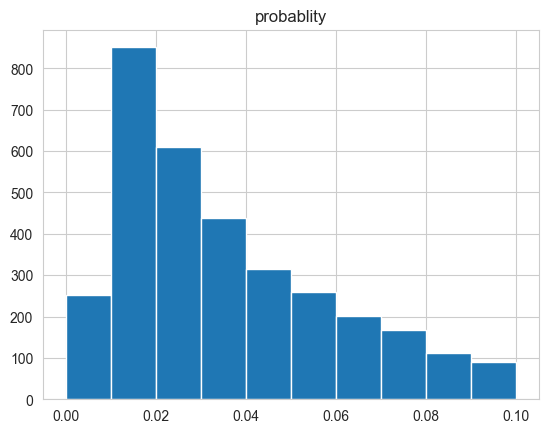

In [153]:
df_test_submit[['probablity']].hist(range=(0,0.1))

# Model calibration using Conformal prediction

In [154]:
from src import VennABERS

In [155]:
X_test = df_test_final[feature_list3]

In [156]:
??VennABERS.ScoresToMultiProbs

Signature: VennABERS.ScoresToMultiProbs(calibrPoints, testObjects)
Docstring: <no docstring>
Source:   
def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1
File:      d:\cv+ job\vpbank entrance\vpbank-project\src\vennabers.py
Type:      function

In [157]:
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [158]:
print(y_train.value_counts())
print(y_calib.value_counts())

86
0    4379
1     278
Name: count, dtype: int64
86
0    1095
1      70
Name: count, dtype: int64


In [159]:
final_clf2 = CatBoostClassifier(**params, silent=True, random_seed=42)
final_clf2.fit(X_train, y_train)

In [ ]:
import pickle
filename = 'models/CatBoostTrial2.sav'
pickle.dump(final_clf2, open(filename, 'wb'))

In [160]:
y_pred_calib = final_clf2.predict(X_calib)
y_pred_score_calib = final_clf2.predict_proba(X_calib)
y_pred_test = final_clf2.predict(X_test)
y_pred_score_test = final_clf2.predict_proba(X_test)

In [161]:
cal_score = y_pred_score_test[:,1]
test_score = y_pred_score_test[:,1]

<Axes: >

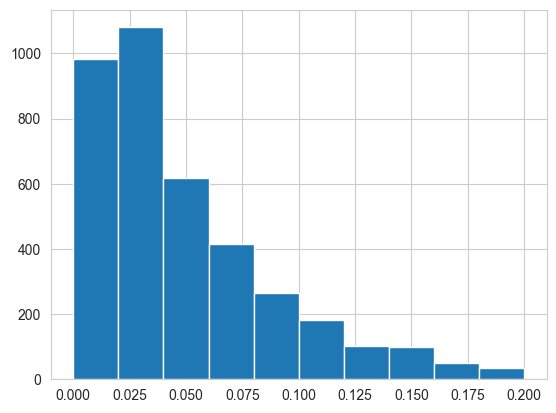

In [162]:
pd.Series(cal_score).hist(range=(0,0.2))

In [163]:
calibrPts = zip(list(cal_score),list(y_calib))

In [164]:
# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set

p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,test_score)

In [165]:
submission_df = pd.DataFrame()
submission_df['p0'] = p0
submission_df['p1'] = p1
submission_df['calibrated_prob'] = p1/(1-p0+p1)
submission_df['uncalibrated_prob']= test_score
submission_df['width_of_prediction_interval'] = submission_df['p1'] - submission_df['p0']

<Axes: >

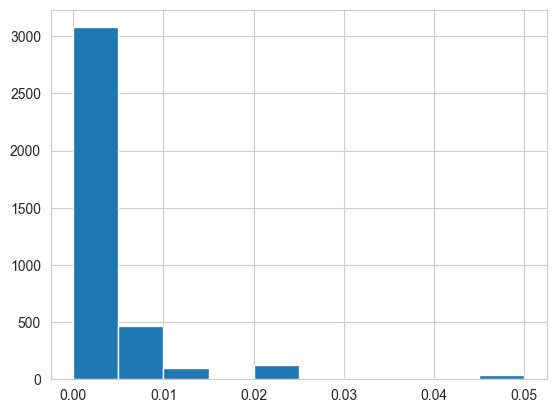

In [166]:
submission_df['width_of_prediction_interval'].hist(range=(0,0.05))

In [172]:
submission_df = submission_df.sort_values(by=['calibrated_prob']).reset_index(drop=True)

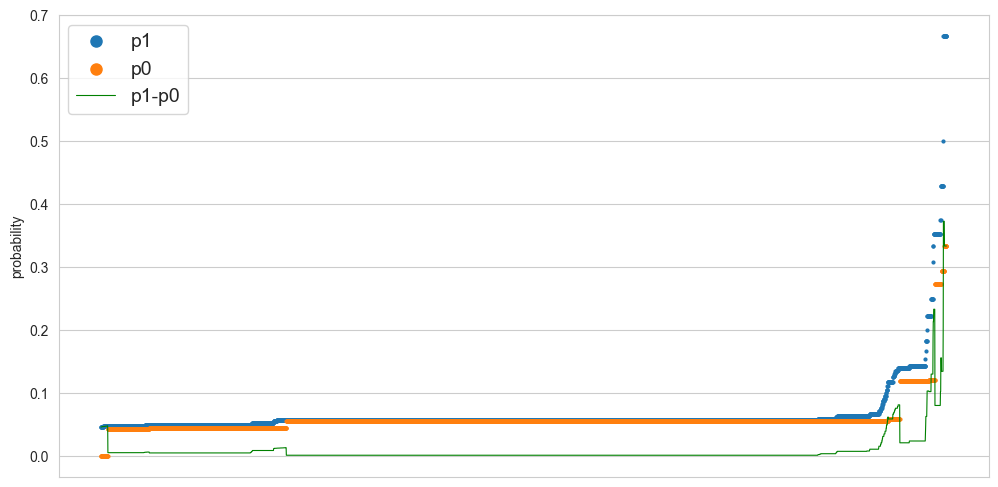

In [173]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=submission_df.index, y=submission_df["p1"],label="p1",s=4)
plt.scatter(x=submission_df.index, y=submission_df["p0"],label="p0",s=4)
plt.plot(submission_df.index, submission_df["width_of_prediction_interval"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.xticks([])
plt.show()

# Interpretation

Text(0.5, 1.0, 'Feature Importance')

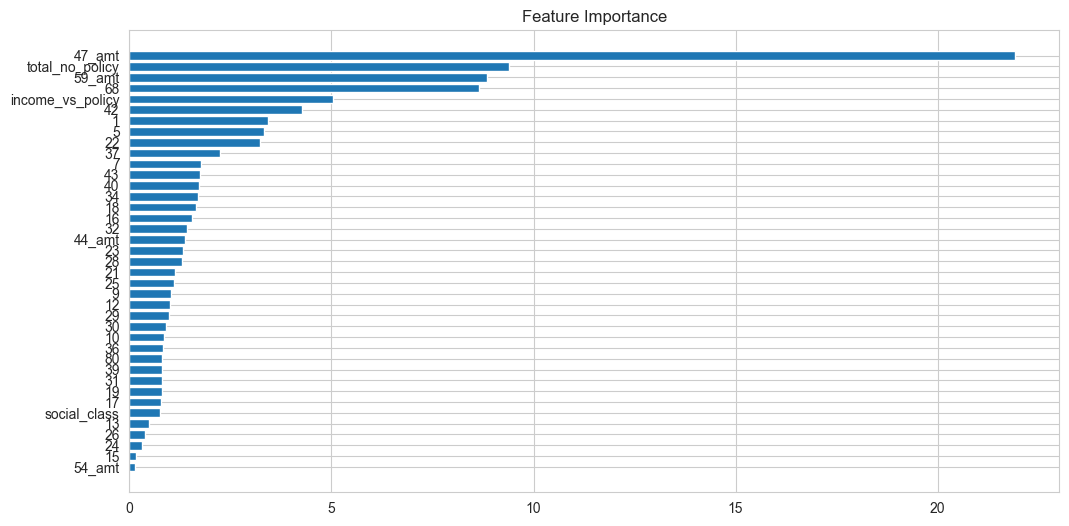

In [174]:
feature_importance = final_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

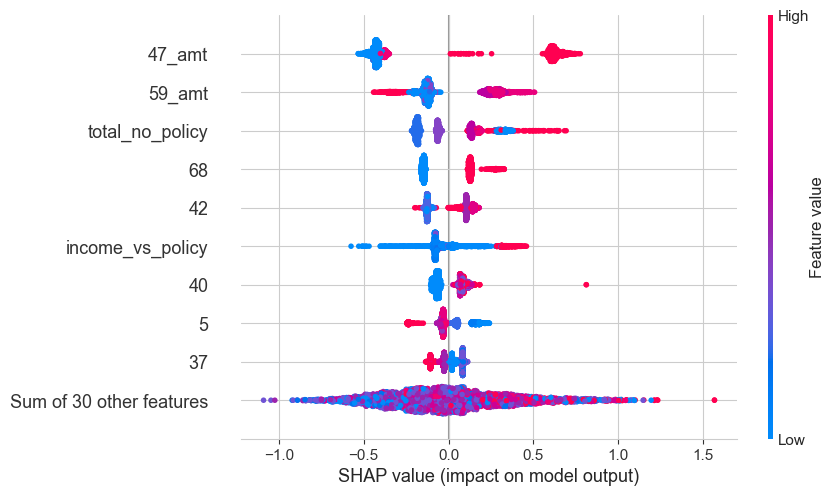

In [175]:
import shap
explainer = shap.TreeExplainer(final_clf)
shap_values = explainer(X_test)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)